# This notebook is to extract cluster with the most DE from network and run it through embedding

In [1]:
import sys
sys.path.append("../..")

import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
from src.eda.eda_functions import *
from src.eda.subset_network import subset_network
from src.eda.process_phenotype import *
from src.embedding.network_embedding import *
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [26]:
prefix = 'G:' if platform == 'win32' else '/Volumes/GoogleDrive'
tom_df = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/Kapoor_TOM.csv', index_col = 0)
comm_df = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/network_louvain_default.csv', index_col = 0)

In [26]:
cluster4_genes = comm_df[comm_df.louvain_label == 4].id

In [27]:
cluster4_tom = tom_df[cluster4_genes]

In [28]:
cluster4_tom = cluster4_tom[cluster4_tom.index.isin(cluster4_genes)]

In [30]:
# cluster4_tom.to_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/cluster4_TOM.csv')

In [12]:
cluster4_tom = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/cluster4_TOM.csv', index_col = 0)

In [13]:
cluster4_tom.head()

,ENSG00000187608,ENSG00000177133,ENSG00000142611,ENSG00000272235,ENSG00000236266,ENSG00000116285,ENSG00000142583,ENSG00000171612,ENSG00000130940,ENSG00000116670,...,ENSG00000156925,ENSG00000185985,ENSG00000171100,ENSG00000102287,ENSG00000182492,ENSG00000089820,ENSG00000196924,ENSG00000160219,ENSG00000155962,ENSG00000224216
ENSG00000187608,1.000000,0.000087,0.000034,0.000018,0.000003,0.000009,0.000029,0.000012,0.000007,0.000018,...,0.000004,0.000018,0.000029,0.000014,0.000072,0.000176,0.000107,0.000063,0.000023,0.000008
ENSG00000177133,0.000087,1.000000,0.016747,0.009040,0.000112,0.000011,0.000048,0.001439,0.000035,0.000128,...,0.000046,0.002943,0.001201,0.000046,0.000558,0.000422,0.000441,0.000140,0.000017,0.000055
ENSG00000142611,0.000034,0.016747,1.000000,0.022895,0.000223,0.000179,0.000422,0.005372,0.000645,0.000480,...,0.000108,0.005985,0.009245,0.000695,0.000657,0.000499,0.000881,0.000436,0.000110,0.000249
ENSG00000272235,0.000018,0.009040,0.022895,1.000000,0.000208,0.000176,0.000435,0.003193,0.000523,0.000451,...,0.000086,0.002665,0.008269,0.000589,0.000462,0.000331,0.001053,0.000456,0.000064,0.000170
ENSG00000236266,0.000003,0.000112,0.000223,0.000208,1.000000,0.000049,0.000032,0.000192,0.000015,0.000006,...,0.000007,0.000155,0.000819,0.000030,0.000034,0.000016,0.000116,0.000043,0.000020,0.000075


In [98]:
genes_to_keep = list(cluster4_tom.sum(axis = 1).sort_values(ascending = False)[:1000].index)

In [99]:
cluster4_subset = cluster4_tom[genes_to_keep]
cluster4_subset = cluster4_subset[cluster4_subset.index.isin(genes_to_keep)]

In [45]:
deseq = pd.read_excel(prefix + '/Shared drives/NIAAA_ASSIST/Data/deseq.alc.vs.control.age.rin.batch.gender.PMI.corrected.w.prot.coding.gene.name.xlsx')

# Check scale-free assumption

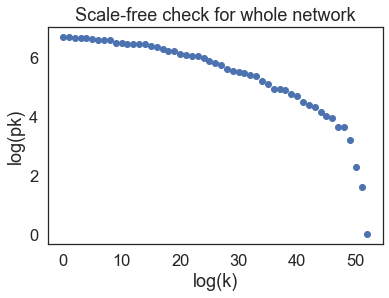

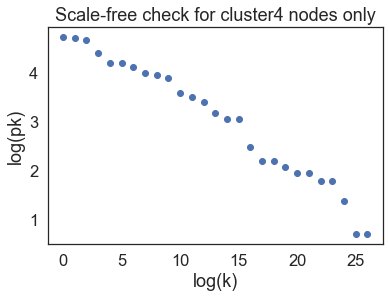

In [100]:
scale_free_validate(tom_df, 'whole network')
scale_free_validate(cluster4_subset, 'cluster4 nodes only')

In [129]:
# make a new df to cluster 4 only subnetwork but instead of subsetting cluster 4, replace all the weights with 0 for nodes not in cluster 4
cluster4_no_cutout = cluster4_subset.copy()
# the nodes that were cut out (non cluster 4 subset genes)
cutout_nodes = list(set(tom_df.columns) - set(cluster4_subset))
col_w_zeros = np.zeros((len(cluster4_subset), len(cutout_nodes))) # 0 to fill the gene columns that aren't in cluster 4
cluster4_no_cutout[cutout_nodes] = col_w_zeros

In [134]:
# df with 0 with fill the gene rows that aren't in cluster 4
to_stack = pd.DataFrame(0, columns = cluster4_no_cutout.columns, index = cutout_nodes)
cluster4_no_cutout = pd.concat([cluster4_no_cutout, to_stack])

# Compare whole and subnetwork distance

In [37]:
# subset networks that keep the edges to compare network distances
subset_networks = []
subset_G = []
for weight in [0.218, 0.24]:
    subset, G = subset_network(tom_df, weight, 0.98)
    subset_networks.append(subset)
    subset_G.append(G)

Number of edges left: 10100.0
Number of edges left: 4967.0


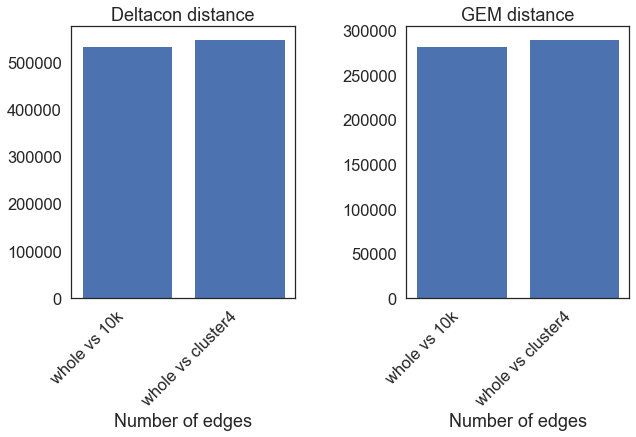

In [137]:
plot_graph_distance([tom_df, subset_networks[0], cluster4_no_cutout], ['whole', '10k', 'cluster4'])

# Compare whole and subnetwork communities

In [144]:
# default setting got 82 clusters. default is not appropriate since this already came from a cluster so a specific setting was used to get 4 clusters only
cluster4_communities = run_louvain(cluster4_subset, resolution = 0.7, n_aggregations = -1) 

In [86]:
# subset 10k edges with nodes removal for fair comparison with cluster 4 (also nodes with degrees = 0 removed)
subset10k_cutout, subset_G = subset_network(tom_df, 0.21, 0.98, 10000)
subset10k_communities = run_louvain(subset10k_cutout)

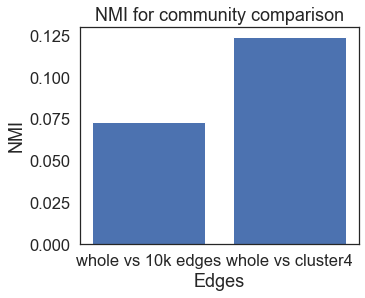

In [145]:
# subnetworks cut out nodes with degree = 0
comparison_names = ['whole vs 10k edges', 'whole vs cluster4']
plot_cluster_nmi_comparison(comm_df, [subset10k_communities, cluster4_communities], 
                            'louvain_label', comparison_names)

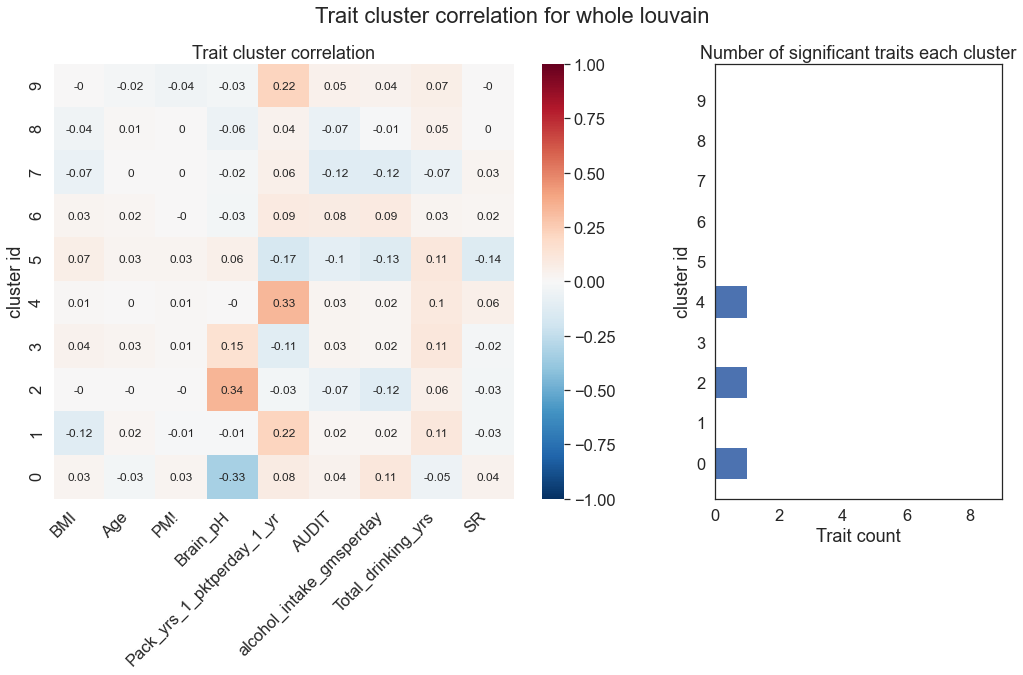

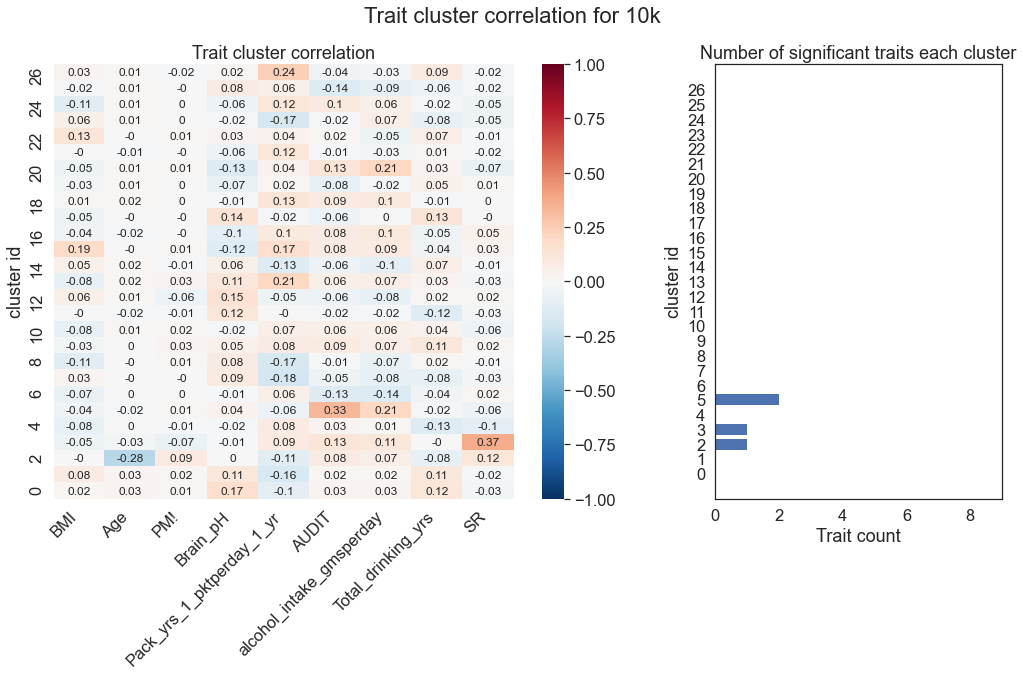

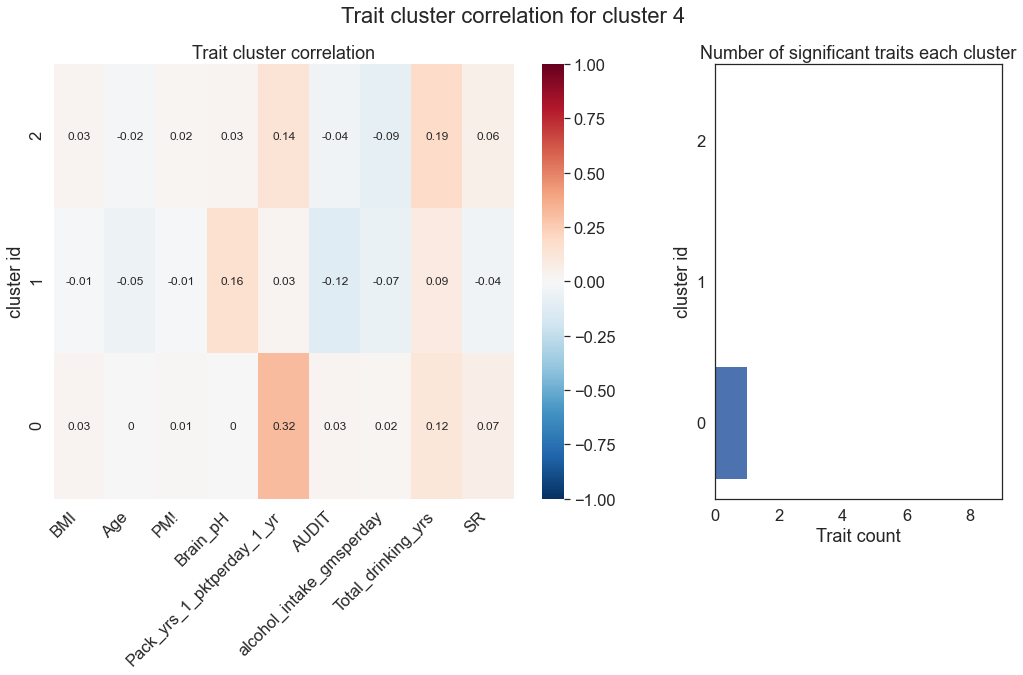

In [146]:
network_names = ['whole louvain', '10k', 'cluster 4']
for i, cluster_df in enumerate([comm_df, subset10k_communities, cluster4_communities]):
    cluster_phenotype_corr(cluster_df, 'louvain_label', network_names[i])

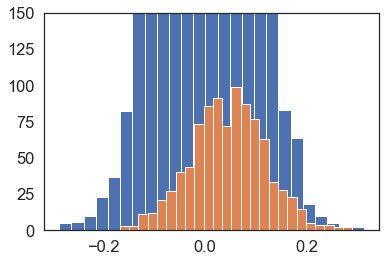

In [148]:
# checking log2FC distribution from deseq and cluster 4 
plt.hist(deseq.log2FoldChange, bins = 25)
plt.hist(deseq[deseq.id.isin(cluster4_subset)].log2FoldChange, bins = 25)
plt.ylim(0, 150);

In [149]:
cluster4_G = nx.convert_matrix.from_pandas_adjacency(cluster4_subset)
cluster4_emb = network_embedding(cluster4_G, 16, 100, 10, 'C:/Users/bbche/Documents/GitRepos/assist/data', 'cluster4')

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 100/100 [03:07<00:00,  1.87s/it]


embedding data saved


In [220]:
parameters = []
kmeans_list = []
for length in [16, 64]:
    for num_walk in [100, 300]:
        emb_df = network_embedding(cluster4_G, length, num_walk, 10, 'C:/Users/bbche/Documents/GitRepos/assist/data/embedding_Nov28', 'cluster4') # use the network with 5k edges as a test (less computationally intensive)
        kmeans_list.append(run_kmeans(emb_df, 4)) # run k means 
        parameters.append(f'length={length},num_walk={num_walk}') # add the parameter name to the parameters list

Computing transition probabilities:   0%|                                                     | 0/1000 [00:00<?, ?it/s]

embedding data saved


Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 300/300 [26:01<00:00,  5.20s/it]


embedding data saved


Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 100/100 [41:37<00:00, 24.98s/it]


embedding data saved


Generating walks (CPU: 1): 100%|███████████████████████████████████████████████████| 300/300 [3:20:32<00:00, 40.11s/it]


embedding data saved


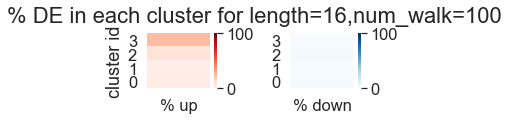

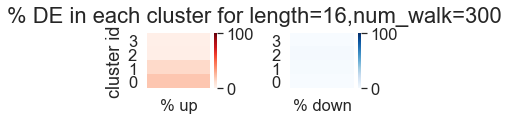

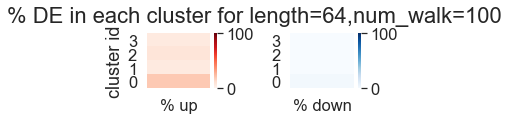

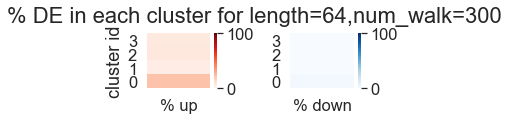

In [221]:
for i in range(4):
    cluster_DE_perc(kmeans_list[i], 'kmean_label', parameters[i])

In [ ]:
# Determine impact vs non-impact proportion and down sample the large group

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score

In [235]:
cluster4_emb = pd.read_csv(r'C:\Users\bbche\Documents\GitRepos\assist\data\embedding_Nov28\embedded_len16_walk300_cluster4.csv',
                           index_col = 0)

In [236]:
cluster4_emb_labeled = pd.merge(cluster4_emb, deseq, left_index = True, right_on = 'id')

In [237]:
cluster4_emb_labeled['impact'] = 1
cluster4_emb_labeled.loc[cluster4_emb_labeled['log2FoldChange'].between(-0.1, 0.1), 'impact'] = 0

In [226]:
cluster4_emb_labeled.impact.value_counts()

0    686
1    239
Name: impact, dtype: int64

In [230]:
lr = LogisticRegression(max_iter = 500)
rf = RandomForestClassifier()
XGB = xgb.XGBClassifier()

In [255]:
for i in range(5):
    cluster4_emb_sampled = cluster4_emb_labeled.groupby('impact').sample(239).reset_index()
    X_train, X_test, y_train, y_test = train_test_split(cluster4_emb_sampled.iloc[:,:64], cluster4_emb_sampled['impact'], test_size = 0.2)
    lr.fit(X_train, y_train)
    rf.fit(X_train, y_train)
    XGB.fit(X_train, y_train)
    print('LR score', lr.score(X_test, y_test))
    print('RF score', rf.score(X_test, y_test))
    predictions = XGB.predict(X_test)
    print('XGB score', accuracy_score(y_test, predictions))


LR score 0.53125
RF score 0.5104166666666666
XGB score 0.5833333333333334
LR score 0.6145833333333334
RF score 0.625
XGB score 0.5208333333333334
LR score 0.5208333333333334
RF score 0.4166666666666667
XGB score 0.4791666666666667
LR score 0.4479166666666667
RF score 0.5
XGB score 0.4895833333333333
LR score 0.53125
RF score 0.5833333333333334
XGB score 0.53125
